In [2]:
import sys
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from models.amp_sim import quads, grover_adaptive
from models.classical import cmaes
from models.parameters import QuadsParam, QuadsHyperParam, CMAParam, CMAHyperParam
from utils.objective_functions import get_rastrigin
import random
import joblib

import pickle


In [6]:
def optimal_num(eval_hist, sample_num):
    return np.arccos(np.sqrt(sample_num/eval_hist))/2/np.arcsin(np.sqrt(sample_num/eval_hist)) + sample_num


[1.0, 1.0, 1.0]
[0.81, 0.21, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.87, 0.85, 0.89, 0.93]


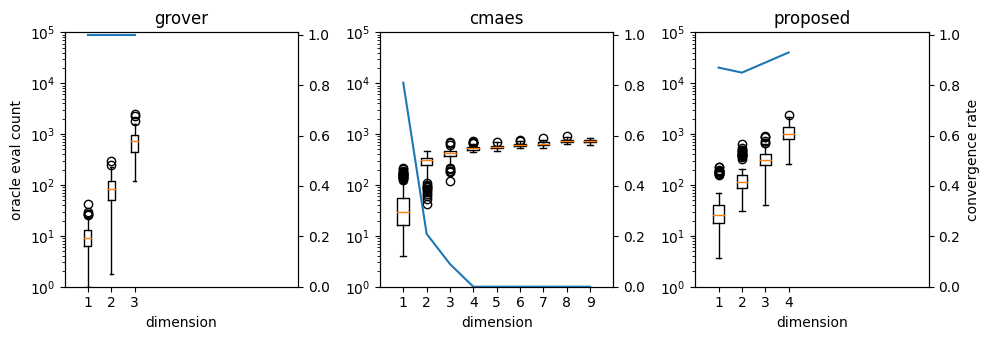

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5))

for i, name in enumerate([ "grover_20230205073651", "cmaes_20230205073651", "quads_20230205073651", ]):
    eval_sums_list = []
    rate_list = []
    for dim in range(1, 10):
        try:
            with open(f"outputs/{name}_{dim}.pickle", "rb") as f:
                npzfile = pickle.load(f)
        except:
            continue
        eval_hists = npzfile["eval_hists"]
        min_val_hists = npzfile["min_func_hists"]
        target_dist_hists = npzfile["dist_target"]
        terminate_dist = npzfile["config"]["terminate_eps"]
        if name.startswith("quads"):
            n_sample = npzfile["config"]["n_samples"]
            eval_sums = np.array([
                np.sum(optimal_num(eval_hist, n_sample)) for eval_hist, target_dist_hist in zip(eval_hists, target_dist_hists)
                    ])
        elif name.startswith("grover"):
            eval_sums = np.array([
                np.sum(optimal_num(eval_hist, 1)) for eval_hist, target_dist_hist in zip(eval_hists, target_dist_hists)
                    ])
        else:
            eval_sums = np.array([
                np.sum(eval_hist) for eval_hist, target_dist_hist in zip(eval_hists, target_dist_hists)])
        eval_sums = sorted(eval_sums)
        eval_sums_list.append(eval_sums)
        convergence_rate = np.mean([target_dist_hist[-1] < terminate_dist for target_dist_hist in target_dist_hists])
        rate_list.append(convergence_rate)

    ax[i].boxplot(eval_sums_list)
    ax[i].set_yscale('log')
    ax[i].set_ylim(1, 1.0e5)
    ax[i].set_xlim(0, 10)
    ax_twin = ax[i].twinx()
    ax_twin.set_ylim(0, 1.01)
    ax_twin.plot(np.arange(1,len(rate_list) + 1), rate_list)
    print(rate_list)

ax_twin.set_ylabel("convergence rate")

ax[0].set_title("grover")
ax[0].set_xlabel("dimension")
ax[0].set_ylabel("oracle eval count")
ax[1].set_title("cmaes")
ax[1].set_xlabel("dimension")
ax[2].set_title("proposed")
ax[2].set_xlabel("dimension")
fig.tight_layout()